# Striplog with a binary 'flag'

We will invent a binary log -- maybe you can load it from an LAS file with `welly`.

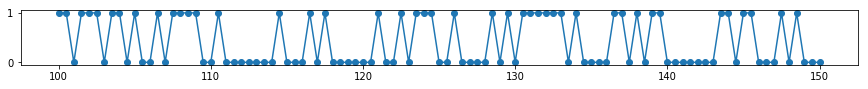

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

fake_depth = np.linspace(100, 150, 101)
fake_log = np.array([np.random.choice([0, 1]) for _ in fake_depth])

plt.figure(figsize=(15, 1))
plt.plot(fake_depth, fake_log, 'o-')

## Make a striplog

A `Striplog` is a sequence of `Interval` objects (representing a layer). Each `Interval` must contain a `Component` (representing the layer, perhaps a rock).

In [2]:
from striplog import Striplog, Component

In [3]:
comps = [
    Component({'pay': True}),
    Component({'pay': False})
]

In [4]:
s = Striplog.from_log(fake_log, cutoff=0.5, components=comps, basis=fake_depth)

In [5]:
s[-1].base.middle = 150.5 # Adjust the bottom thickness... not sure if this is a bug.

Each `Interval` in the striplog looks like:

In [6]:
s[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 101.0, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': False})]})

## Plot the intervals

To plot we need a legend, but we can generate a random one. This maps each `Component` to a colour (and a width and hatch, if you want).

We can generate a random legend:

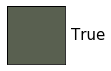

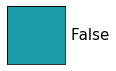

In [7]:
from striplog import Legend

legend = Legend.random(comps)
legend.get_decor(comps[-1]).width = 0.2
legend.plot()

Or we can make one with a bit more control:

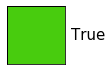

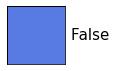

In [8]:

legend_csv = """colour,hatch,width,component pay
#48cc0e,None,1,True
#5779e2,None,0.2,False"""

legend = Legend.from_csv(text=legend_csv)

legend.plot()

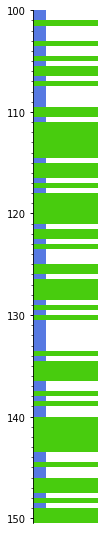

In [9]:
s.plot(legend=legend, aspect=5)

## Remove thin things

We can remove thin intervals:

In [10]:
pruned = s.prune(limit=1.0, keep_ends=True)

Now we can anneal the gaps:

In [11]:
annealed = pruned.anneal()

Then merge the adjacent intervals that are alike...

In [12]:
merged = annealed.merge_neighbours()  # Anneal works on a copy

We could have chained these commands:

    merged = s.prune(limit=1.0, keep_ends=True).anneal().merge_neighbours()

Let's plot all these steps, just for illustration:

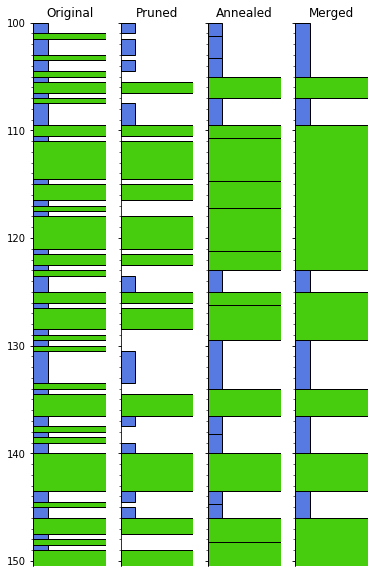

In [13]:
fig, axs = plt.subplots(ncols=4, figsize=(6, 10))

axs[0] = s.plot(legend=legend, ax=axs[0], lw=1, aspect=5)
axs[0].set_title('Original')
axs[1] = pruned.plot(legend=legend, ax=axs[1], lw=1, aspect=5)
axs[1].set_yticklabels([])
axs[1].set_title('Pruned')
axs[2] = annealed.plot(legend=legend, ax=axs[2], lw=1, aspect=5)
axs[2].set_yticklabels([])
axs[2].set_title('Annealed')
axs[3] = merged.plot(legend=legend, ax=axs[3], lw=1, aspect=5)
axs[3].set_yticklabels([])
axs[3].set_title('Merged')
plt.show()

## Dilate and erode

This would be a binary thing, at least for now. I made an issue for this: https://github.com/agile-geoscience/striplog/issues/95

You need to be on striplog v 0.8.1 at least for this to work.

In [14]:
from scipy.ndimage import morphology as bm

# Assumption:
# If the first (Python 3.6, 3.7) component item has a boolean value
# Then it's a 'binary striplog'. 
#
# Question: 
# Would it be better to subclass Striplog and make BinaryStriplog?
# Which could only have one field in the primary component.

def is_binary(strip):
    """Determine if this striplog is interpretable as a binary striplog.
    """
    primaries = [list(i.primary.__dict__.values())[0] for i in strip]
    return all(map(lambda x: isinstance(x, bool), primaries))

def is_interval_true(interval):
    return list(interval.primary.__dict__.values())[0]

def is_comp_true(comp):
    return list(comp.__dict__.values())[0]

def binary_log(strip, step):
    log, basis, comps = s.to_log(step=step, undefined=-1, return_meta=True)
    if -1 in log:
        print("We have undefined values, there might be a problem.")
    return log - 1, basis, comps

def binary_operation(strip, operation, step=1, structure=None):
    ops = {
        'erosion': bm.binary_erosion,
        'dilation': bm.binary_dilation,
        'opening': bm.binary_opening,
        'closing': bm.binary_closing,
    }
    if not is_binary(strip):
        print("Cannot interpret striplog as binary.")
    log, basis, comps = binary_log(strip, step=step)
    if structure is None:
        raise TypeError("Structure cannot be None")
    try:   # Treat as int
        element = np.ones(int(structure))
    except:
        element = structure

    proc = ops[operation](log, structure=element)
    if operation == 'closing':
        proc = proc | log
    s = Striplog.from_log(proc, components=comps, basis=basis)
    return s
    
def generalize(strip, method=None):
    if method is None:
        method = 'closing'

In [15]:
def net_to_gross(strip):
    net = non = 0
    for c, x in strip.unique:
        if is_comp_true(c):
            net = x
        else:
            non = x
    return net / (net + non)

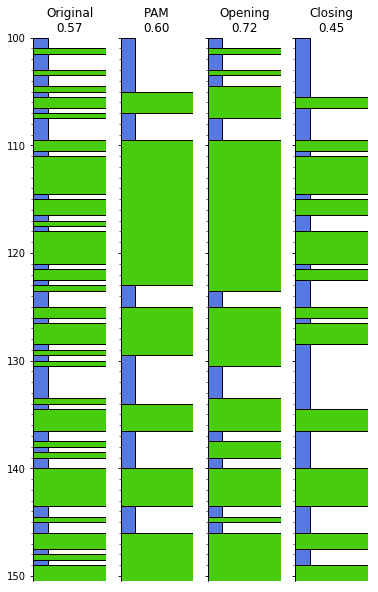

In [16]:
fig, axs = plt.subplots(ncols=4, figsize=(6, 10))

opening = binary_operation(s, 'opening', step=0.1, structure=7)
closing = binary_operation(s, 'closing', step=0.1, structure=7)

axs[0] = s.plot(legend=legend, ax=axs[0], lw=1, aspect=5)
ntg = net_to_gross(s)
axs[0].set_title(f'Original\n{ntg:.2f}')
axs[1] = merged.plot(legend=legend, ax=axs[1], lw=1, aspect=5)
axs[1].set_yticklabels([])
ntg = net_to_gross(merged)
axs[1].set_title(f'PAM\n{ntg:.2f}')  # Prune-anneal-merge
axs[2] = opening.plot(legend=legend, ax=axs[2], lw=1, aspect=5)
axs[2].set_yticklabels([])
ntg = net_to_gross(opening)
axs[2].set_title(f'Opening\n{ntg:.2f}')
axs[3] = closing.plot(legend=legend, ax=axs[3], lw=1, aspect=5)
axs[3].set_yticklabels([])
ntg = net_to_gross(closing)
axs[3].set_title(f'Closing\n{ntg:.2f}')
plt.show()

## Some statistics

We can get the unique components and their thicknesses:

In [15]:
s.unique

[(Component({'pay': 'non-pay'}), 25.5), (Component({'pay': 'pay'}), 25.0)]

We can get at the thickest (and thinnest, with `.thinnest()`) intervals:

In [16]:
s.thickest()

Interval({'top': Position({'middle': 104.0, 'units': 'm'}), 'base': Position({'middle': 108.0, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'pay': 'pay'})]})

These functions optionally take an integer argument `n` specifying how many of the thickest or thinnest intervals you want to see. If `n` is greater than 1, a `Striplog` object is returned so you can see the positions of those items:

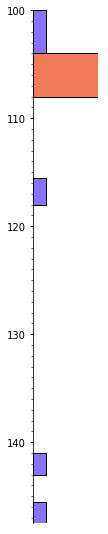

In [17]:
s.thickest(5).plot(legend=legend, lw=1, aspect=5)

## Bar plots and histograms

We can make a bar plot of the layers:

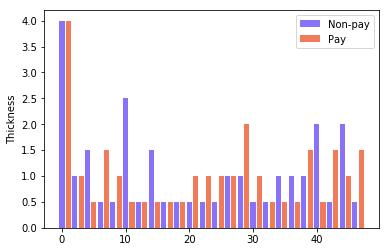

In [18]:
s.bar(legend=legend)

More interesting is to sort the thicknesses:

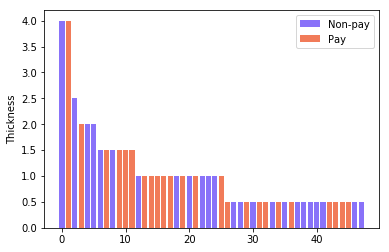

In [19]:
s.bar(legend=legend, sort=True)

Finally, we can make a thickness histogram of the various types of `component` present in the log.

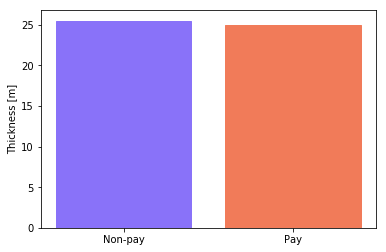

In [27]:
n, ents, ax = s.hist(legend=legend)